Importation des packages

Description des variables de ce dataframe :
- idmutinvar = identifiant unique entre les diff bases pour retrouver chaque mutation
- idopendata = identifiant de mutation utilisé depuis l'ouverture de données DVF
- datemut = date de signature de l'acte de vente
- anneemut = annee de signature du doc
- codedep
- libnatmut = Libellé de nature de mutation tel que défini dans la donnée source DVF 6 catégories : Vente, Vente en l'état futur d'achèvement, Adjudication, Echange, Vente terrain à bâtir et Expropriation.
- vefa = booléen selon si la vente est en VEFA (vente en l'état futur d'achèvement) ou non
- valeurfonc = valeur foncière en euro déclarée lors de la vente ; prix net vendeur, inclut la TVA mais n'inclut pas les frais de notaire, d'agence ou des meubles. 
- nbcomm = nombre de communes concernée par la mutation (i.e. sur lesquelles se trouve la parcelle cadastrale concernée par la mutation)
- nbpar = comme nbcomm mais pour les parcelles.
- nbparmut = nb de parcelles ayant muté (i.e. dont la pleine propriété a été transférée lors de la mutation)
- sterr = surface de terrain ayant muté (mutation = transfert de propriété, donc surface de terrain ayant muté = surface du terrain qui a été vendu)
- nbvolmut = variable obscure, flemme 
- nblocmut = nb de locaux ayant muté
- sbati = surface de l'ensemble du bati ayant muté
- codtypbien = typologie des biens ; on pourra s'en servir pour filter les maisons et appartements et virer tous les types de batiments bizarres (cf schéma ici) https://doc-datafoncier.cerema.fr/doc/dv3f/mutation/codtypbien
- libtypbien = comme codtypbien mais pour la base DV3F et non issu de juste DVF
- geometry
- l_codeinsee = liste des codes INSEE des communes concernées par la mutation
- l_idpar =Liste des idpar qui composent l’entité (idpar = Identifiant de parcelle)
- l_idparmut = liste des identifiants de parcelles ayant muté (idpar)
- l_idlocmut = liste des identifiants de locaux ayant muté (idloc)

On peut regarder la documentation de la base DVF sur le site suivant : 
https://apidf-preprod.cerema.fr/swagger/#/DVF%2B%20(acc%C3%A8s%20libre)/dvf_opendata_geomutations_list


In [59]:
!pip install py7zr geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette

  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-la0l4clv
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-la0l4clv
  Resolved https://github.com/inseefrlab/cartiflette to commit 2e38b5f829df6a6fa1578268112ff88853c9a4bf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [60]:
import pandas as pd
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
from zipfile import ZipFile
import cartiflette
from io import StringIO

Paramétrage de l'API

In [61]:
BASE_URL_API = "https://apidf-preprod.cerema.fr"
#code_insee, nom =  "59512", "Roubaix" #"75015", "Paris"
code_insee = "78220"
url = BASE_URL_API + f"/dvf_opendata/geomutations/?code_insee={code_insee}"
# %% 
print(url)

https://apidf-preprod.cerema.fr/dvf_opendata/geomutations/?code_insee=78220


In [62]:
response = requests.get(url)#, params=params)
# Vérification du succès de la requête
if response.status_code == 200:
    data = response.json()  # On récupère les données au format JSON
else:
    print(f"Erreur : {response.status_code}")
# %%
print(type(data))
print(data.keys())

<class 'dict'>
dict_keys(['type', 'count', 'next', 'previous', 'features'])


Data est un dictionnaire ; on va transformer son entrée "features" en un dataframe python

In [63]:
print(data["features"])

[{'id': 10179531, 'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[1.893641, 48.715958], [1.893816, 48.71591], [1.894018, 48.715854], [1.894154, 48.715816], [1.894197, 48.715913], [1.894273, 48.715899], [1.89426, 48.715866], [1.894305, 48.715859], [1.894319, 48.715893], [1.894332, 48.715927], [1.89444, 48.716185], [1.894394, 48.716192], [1.894373, 48.716195], [1.894321, 48.716185], [1.894316, 48.716173], [1.894243, 48.716191], [1.894173, 48.716207], [1.894142, 48.716163], [1.894127, 48.716142], [1.894044, 48.716167], [1.894041, 48.716167], [1.89401, 48.716165], [1.893942, 48.716163], [1.893809, 48.716157], [1.893722, 48.716153], [1.893641, 48.715958]]]]}, 'properties': {'idmutinvar': '02770392cd0518ff5cfedef603fbe5e8', 'idopendata': '02770392cd0518ff5cfedef603fbe5e8', 'datemut': '2024-01-08', 'anneemut': 2024, 'coddep': '78', 'libnatmut': 'Vente', 'vefa': False, 'valeurfonc': '280740.00', 'nbcomm': 1, 'l_codinsee': ['78220'], 'nbpar': 1, 'l_idpar': ['78220000A

In [64]:
# Conversion en DataFrame pandas
df = pd.DataFrame(data["features"])
print(df.head())
print(df.columns)

         id     type                                           geometry  \
0  10179531  Feature  {'type': 'MultiPolygon', 'coordinates': [[[[1....   
1  10179925  Feature  {'type': 'MultiPolygon', 'coordinates': [[[[1....   
2  10179958  Feature  {'type': 'MultiPolygon', 'coordinates': [[[[1....   
3  10180369  Feature  {'type': 'MultiPolygon', 'coordinates': [[[[1....   
4  10180454  Feature  {'type': 'MultiPolygon', 'coordinates': [[[[1....   

                                          properties  
0  {'idmutinvar': '02770392cd0518ff5cfedef603fbe5...  
1  {'idmutinvar': '0fd6a5a5302c8f571b609895e6b8d0...  
2  {'idmutinvar': '7c302dd087b66bc3ed16e217713986...  
3  {'idmutinvar': '5a54c5ecc046b898a465647c288a07...  
4  {'idmutinvar': 'de094980803a4d6c80831ae8a99f1f...  
Index(['id', 'type', 'geometry', 'properties'], dtype='object')


In [65]:
df.head(1)

,id,type,geometry,properties
0,10179531,Feature,"{'type': 'MultiPolygon', 'coordinates': [[[[1....",{'idmutinvar': '02770392cd0518ff5cfedef603fbe5...


On a importé un fichier geojson mais qu'on a traité comme un json classique ; le code ci-dessous vise à mieux prendre en compte cette dimension spatiale (et le côté "geo" du fichier geojson)

In [70]:
mut_gdf_old = gpd.read_file(StringIO(response.text))

# Afficher un aperçu des données
print(mut_gdf_old.head())

Skipping field l_codinsee: unsupported OGR type: 5
Skipping field l_idpar: unsupported OGR type: 5
Skipping field l_idparmut: unsupported OGR type: 5
Skipping field l_idlocmut: unsupported OGR type: 5


                         idmutinvar                        idopendata  \
0  02770392cd0518ff5cfedef603fbe5e8  02770392cd0518ff5cfedef603fbe5e8   
1  0fd6a5a5302c8f571b609895e6b8d0b0  0fd6a5a5302c8f571b609895e6b8d0b0   
2  7c302dd087b66bc3ed16e217713986a4  7c302dd087b66bc3ed16e217713986a4   
3  5a54c5ecc046b898a465647c288a0729  5a54c5ecc046b898a465647c288a0729   
4  de094980803a4d6c80831ae8a99f1f14  de094980803a4d6c80831ae8a99f1f14   

     datemut  anneemut coddep libnatmut   vefa valeurfonc  nbcomm  nbpar  \
0 2024-01-08      2024     78     Vente  False  280740.00       1      1   
1 2024-01-23      2024     78     Vente  False  120000.00       1      1   
2 2024-04-04      2024     78     Vente  False  465000.00       2      2   
3 2024-02-15      2024     78     Vente  False   90000.00       1      1   
4 2024-06-28      2024     78     Vente  False  498874.00       1      1   

   nbparmut    sterr  nbvolmut  nblocmut   sbati codtypbien  \
0         0     0.00         0         3 

In [71]:
mut_gdf_old.shape

(100, 18)

Ok, mieux, mais il faudrait comprendre et régler ce qui s'affiche juste au dessus "Skipping field l_codinsee: unsupported OGR type: 5" (et les autres erreurs du même type)

On voit qu'il s'agit des variables qui sont de type listes (d'où le "l_"). Il faudrait changer ça. 

In [9]:
print(data['features'][0]['properties'])

{'idmutinvar': '02770392cd0518ff5cfedef603fbe5e8', 'idopendata': '02770392cd0518ff5cfedef603fbe5e8', 'datemut': '2024-01-08', 'anneemut': 2024, 'coddep': '78', 'libnatmut': 'Vente', 'vefa': False, 'valeurfonc': '280740.00', 'nbcomm': 1, 'l_codinsee': ['78220'], 'nbpar': 1, 'l_idpar': ['78220000AN0156'], 'nbparmut': 0, 'l_idparmut': None, 'sterr': '0.00', 'nbvolmut': 0, 'nblocmut': 3, 'l_idlocmut': ['782200015592988_0', '782200015592989_0', '782200015592990_0'], 'sbati': '90.00', 'codtypbien': '121', 'libtypbien': 'UN APPARTEMENT'}


Voilà la solution : 

In [10]:
for feature in data["features"]:
    properties = feature["properties"]
    for key, value in properties.items():
        if isinstance(value, list):  # Vérifie si c'est une liste
            properties[key] = ", ".join(map(str, value))  # Convertit en chaîne séparée par des virgules

mut_gdf = gpd.GeoDataFrame.from_features(data["features"])


Vérifions : 

In [11]:
a = 0
for i in list(mut_gdf_old.keys()):
    a+=1
print(a)

18


In [12]:
mut_gdf.head()

,geometry,idmutinvar,idopendata,datemut,anneemut,coddep,libnatmut,vefa,valeurfonc,nbcomm,...,l_idpar,nbparmut,l_idparmut,sterr,nbvolmut,nblocmut,l_idlocmut,sbati,codtypbien,libtypbien
0,"MULTIPOLYGON (((1.89364 48.71596, 1.89382 48.7...",02770392cd0518ff5cfedef603fbe5e8,02770392cd0518ff5cfedef603fbe5e8,2024-01-08,2024,78,Vente,False,280740.00,1,...,78220000AN0156,0,None,0.00,0,3,"782200015592988_0, 782200015592989_0, 78220001...",90.00,121,UN APPARTEMENT
1,"MULTIPOLYGON (((1.89657 48.71715, 1.89666 48.7...",0fd6a5a5302c8f571b609895e6b8d0b0,0fd6a5a5302c8f571b609895e6b8d0b0,2024-01-23,2024,78,Vente,False,120000.00,1,...,78220000AO0239,0,None,0.00,1,0,None,0.00,102,BATI - INDETERMINE : Vente avec volume(s)
2,"MULTIPOLYGON (((1.90259 48.72143, 1.90255 48.7...",7c302dd087b66bc3ed16e217713986a4,7c302dd087b66bc3ed16e217713986a4,2024-04-04,2024,78,Vente,False,465000.00,2,...,"78220000AP0121, 783340000B2313",2,"78220000AP0121, 783340000B2313",1014.00,0,4,"783340015600465_0, 783340015600466_0, 78334001...",326.00,152,BATI MIXTE - LOGEMENT/ACTIVITE
3,"MULTIPOLYGON (((1.89921 48.71781, 1.8996 48.71...",5a54c5ecc046b898a465647c288a0729,5a54c5ecc046b898a465647c288a0729,2024-02-15,2024,78,Vente,False,90000.00,1,...,78220000AO0219,0,None,0.00,0,3,"782200015595267_0, 782200015595268_0, 78220001...",34.00,121,UN APPARTEMENT
4,"MULTIPOLYGON (((1.90013 48.71268, 1.90016 48.7...",de094980803a4d6c80831ae8a99f1f14,de094980803a4d6c80831ae8a99f1f14,2024-06-28,2024,78,Vente,False,498874.00,1,...,78220000AM0025,1,78220000AM0025,983.00,0,1,782200015606002_0,170.00,111,UNE MAISON


Les colonnes ont pour la plupart des types "object" qui nous empêchent de travailler : 

In [13]:
mut_gdf.dtypes

geometry      geometry
idmutinvar      object
idopendata      object
datemut         object
anneemut         int64
coddep          object
libnatmut       object
vefa              bool
valeurfonc      object
nbcomm           int64
l_codinsee      object
nbpar            int64
l_idpar         object
nbparmut         int64
l_idparmut      object
sterr           object
nbvolmut         int64
nblocmut         int64
l_idlocmut      object
sbati           object
codtypbien      object
libtypbien      object
dtype: object

On peut changer le type d'une colonne en un autre type à spécifier. Par exemple, pour changer 'sterr' en décimaux : 

In [14]:
mut_gdf['sterr']  = mut_gdf["sterr"].astype(float)

On peut vérifier :

In [57]:
mut_gdf.dtypes

geometry      geometry
idmutinvar      object
idopendata      object
datemut         object
anneemut         int64
coddep          object
libnatmut       object
vefa              bool
valeurfonc      object
nbcomm           int64
l_codinsee      object
nbpar            int64
l_idpar         object
nbparmut         int64
l_idparmut      object
sterr          float64
nbvolmut         int64
nblocmut         int64
l_idlocmut      object
sbati           object
codtypbien      object
libtypbien      object
dtype: object

In [69]:
mut_gdf_old.shape

(100, 18)

On cherche une API pour les données par IRIS

In [ ]:

BASE_URL_API_IRIS = "https://pyris.datajazz.io/api/" 
code_iris = "786860101"
url_iris_pop = BASE_URL_API_IRIS + f"insee/population/{code_iris}"
url_iris_log = BASE_URL_API_IRIS + f"insee/logement/{code_iris}"
url_iris_act = BASE_URL_API_IRIS + f"insee/activite/{code_iris}"
# %% 
print(url_iris)

In [ ]:
response_iris_pop = requests.get(url_iris_pop)
response_iris_log = requests.get(url_iris_log)
response_iris_act = requests.get(url_iris_act)

# Vérification du succès de la requête
if response_iris.status_code == 200:
    data_iris_pop = response_iris_pop.json()
    data_iris_log = response_iris_log.json()
    data_iris_act = response_iris_act.json()
    data_iris_all = data_iris_pop | data_iris_log | data_iris_act
else:
    print(f"Erreur : {response_iris.status_code}")
# %%

In [ ]:
print(data_iris_pop.keys())
print(data_iris_log.keys())
print(data_iris_act.keys())
print(data_iris_all.keys())

Puisqu'on ne trouve pas d'API permettant de récupérer les données voulues, on essaie avec des données csv Insee

In [15]:
zip_file = ZipFile('data/BASE_TD_FILO_DISP_IRIS_2020_CSV.zip')
data_rev_disp_2020 = pd.read_csv(zip_file.open("BASE_TD_FILO_DISP_IRIS_2020.csv"), sep = ";")

In [16]:
data_rev_disp_2020.head()

,IRIS,DISP_TP6020,DISP_Q120,DISP_MED20,DISP_Q320,DISP_EQ20,DISP_D120,DISP_D220,DISP_D320,DISP_D420,...,DISP_PCHO20,DISP_PBEN20,DISP_PPEN20,DISP_PPAT20,DISP_PPSOC20,DISP_PPFAM20,DISP_PPMINI20,DISP_PPLOGT20,DISP_PIMPOT20,DISP_NOTE20
0,010040101,"20,3",14280,19450,25490,"0,58",11000,13350,15320,17530,...,"3,7","2,9","27,9","6,4","10,3","3,5","4,7","2,1","-12,3",0
1,010040102,"25,6",13280,17910,23920,"0,59",10120,12460,14200,15830,...,"4,4","2,3","24,8","6,0","12,7","3,9","5,9","2,9","-11,8",0
2,010040201,"18,4",14890,20210,26620,"0,58",11240,13860,15990,18190,...,"3,8","3,4","28,0","6,5","8,7","3,0","3,7","2,0","-13,9",0
3,010040202,"8,4",19060,24870,32100,"0,52",14380,17560,20110,22590,...,"2,8","3,8","25,0","10,8","4,7","2,0","1,9","0,8","-17,0",0
4,010330102,"22,9",14000,19810,29190,"0,77",9380,12670,15070,17560,...,"4,9","1,7","24,1","6,5","6,0","1,5","3,0","1,5","-13,0",0


On va chercher tous les IRIS de Paris 15ème

In [17]:
base_url_iris = "https://pyris.datajazz.io/api/city/code"

code_insee = "75115" #attention, un code Insee n'est que rarement le code postal
url_iris_code = base_url_iris + f"/{code_insee}"
# %% 
print(url_iris_code)

response = requests.get(url_iris_code)#, params=params)
# Vérification du succès de la requête
if response.status_code == 200:
    data_iris = response.json()  # On récupère les données au format JSON
else:
    print(f"Erreur : {response.status_code}")
# %%
print(type(data_iris))
print(data_iris) #on a la lis

https://pyris.datajazz.io/api/city/code/75115
<class 'list'>
['751155912', '751155711', '751155721', '751156021', '751155718', '751155717', '751155716', '751155712', '751155710', '751155808', '751156023', '751155914', '751155908', '751156012', '751155703', '751155911', '751155707', '751155907', '751155731', '751155999', '751156007', '751156019', '751156017', '751155809', '751156013', '751155708', '751155702', '751156005', '751156010', '751155705', '751155812', '751155803', '751155813', '751155810', '751155801', '751155723', '751156020', '751155704', '751155804', '751155903', '751155805', '751155720', '751155919', '751156006', '751155904', '751156008', '751155729', '751155909', '751156018', '751155910', '751156015', '751156004', '751155730', '751155915', '751155715', '751156002', '751155819', '751156001', '751155815', '751155920', '751155714', '751155807', '751155701', '751156016', '751155814', '751155802', '751155816', '751155706', '751155916', '751156009', '751155902', '751155713', '7

On a ainsi obtenu la liste des IRIS présents dans Paris 15ème
On va maintenant obtenir les coordonnées géographiques de tous ces IRIS

Dans l'autre sens : on part des adresses et on leur attribue leur IRIS

Ci-dessous : voici comment récupérer l'IRIS d'une coordonnée géographique
Problème : si on doit requêter les coordonnées de toutes les adresses qui nous intéresse, ça pourrait être un peu fastidieux


In [ ]:
base_url_api = "https://pyris.datajazz.io/api/"
lat, lon = 48.71715, 1.89657

url_adresse_to_iris = base_url_api + f"coords?geojson=true&lat={lat}&lon={lon}"
# %% 
print(url_adresse_to_iris)

response_adresse_to_iris = requests.get(url_adresse_to_iris)#, params=params)
# Vérification du succès de la requête
if response_adresse_to_iris.status_code == 200:
    data_adresse_to_iris = response_adresse_to_iris.json()  # On récupère les données au format JSON
    print("ok")
else:
    print(f"Erreur : {response_adresse_to_iris.status_code}")
# %%
print(type(data_adresse_to_iris))
print(data_adresse_to_iris) 

Puisque c'est un peu laborieux, dans l'autre sens : on a récupéré un fichier des coordonnées spatiales des IRIS en ile de France

In [18]:
iris = gpd.read_file("data/iris.geojson")  
iris = iris.to_crs(epsg=4326)  # Assurez-vous d'utiliser le même système de coordonnées (WGS84)

On regarde dans quel système géographique est le tableau geopandas des données DVF

In [19]:
mut_gdf_old["geometry"].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Ok, on est bien en format 4326 (=WGS 84) pour les deux fichiers, on va pouvoir affecter des IRIS à nos adresses de la base DVF (pour ensuite relier ça aux fichiers Insee)

In [20]:
data_mut_avec_iris = gpd.sjoin(mut_gdf_old, iris, how="left", predicate="intersects")

# Vérifier les résultats
print(data_mut_avec_iris.head())

                         idmutinvar                        idopendata  \
0  02770392cd0518ff5cfedef603fbe5e8  02770392cd0518ff5cfedef603fbe5e8   
1  0fd6a5a5302c8f571b609895e6b8d0b0  0fd6a5a5302c8f571b609895e6b8d0b0   
2  7c302dd087b66bc3ed16e217713986a4  7c302dd087b66bc3ed16e217713986a4   
3  5a54c5ecc046b898a465647c288a0729  5a54c5ecc046b898a465647c288a0729   
4  de094980803a4d6c80831ae8a99f1f14  de094980803a4d6c80831ae8a99f1f14   

     datemut  anneemut coddep libnatmut   vefa valeurfonc  nbcomm  nbpar  ...  \
0 2024-01-08      2024     78     Vente  False  280740.00       1      1  ...   
1 2024-01-23      2024     78     Vente  False  120000.00       1      1  ...   
2 2024-04-04      2024     78     Vente  False  465000.00       2      2  ...   
3 2024-02-15      2024     78     Vente  False   90000.00       1      1  ...   
4 2024-06-28      2024     78     Vente  False  498874.00       1      1  ...   

                                            geometry index_right  \
0  MUL

Les iris apparaissent bien dans le fichier des mutations
Dernière étape : relier ça aux données Insee "test" (celle des revenus disp de 2020)

In [21]:
data_mut_et_insee = data_mut_avec_iris.join(data_rev_disp_2020, how="left")

In [22]:
data_mut_et_insee.head(5)

,idmutinvar,idopendata,datemut,anneemut,coddep,libnatmut,vefa,valeurfonc,nbcomm,nbpar,...,DISP_PCHO20,DISP_PBEN20,DISP_PPEN20,DISP_PPAT20,DISP_PPSOC20,DISP_PPFAM20,DISP_PPMINI20,DISP_PPLOGT20,DISP_PIMPOT20,DISP_NOTE20
0,02770392cd0518ff5cfedef603fbe5e8,02770392cd0518ff5cfedef603fbe5e8,2024-01-08,2024,78,Vente,False,280740.00,1,1,...,"3,7","2,9","27,9","6,4","10,3","3,5","4,7","2,1","-12,3",0
1,0fd6a5a5302c8f571b609895e6b8d0b0,0fd6a5a5302c8f571b609895e6b8d0b0,2024-01-23,2024,78,Vente,False,120000.00,1,1,...,"4,4","2,3","24,8","6,0","12,7","3,9","5,9","2,9","-11,8",0
2,7c302dd087b66bc3ed16e217713986a4,7c302dd087b66bc3ed16e217713986a4,2024-04-04,2024,78,Vente,False,465000.00,2,2,...,"3,8","3,4","28,0","6,5","8,7","3,0","3,7","2,0","-13,9",0
3,5a54c5ecc046b898a465647c288a0729,5a54c5ecc046b898a465647c288a0729,2024-02-15,2024,78,Vente,False,90000.00,1,1,...,"2,8","3,8","25,0","10,8","4,7","2,0","1,9","0,8","-17,0",0
4,de094980803a4d6c80831ae8a99f1f14,de094980803a4d6c80831ae8a99f1f14,2024-06-28,2024,78,Vente,False,498874.00,1,1,...,"4,9","1,7","24,1","6,5","6,0","1,5","3,0","1,5","-13,0",0


On commence à faire vite-fait un peu de visualisation spatiale

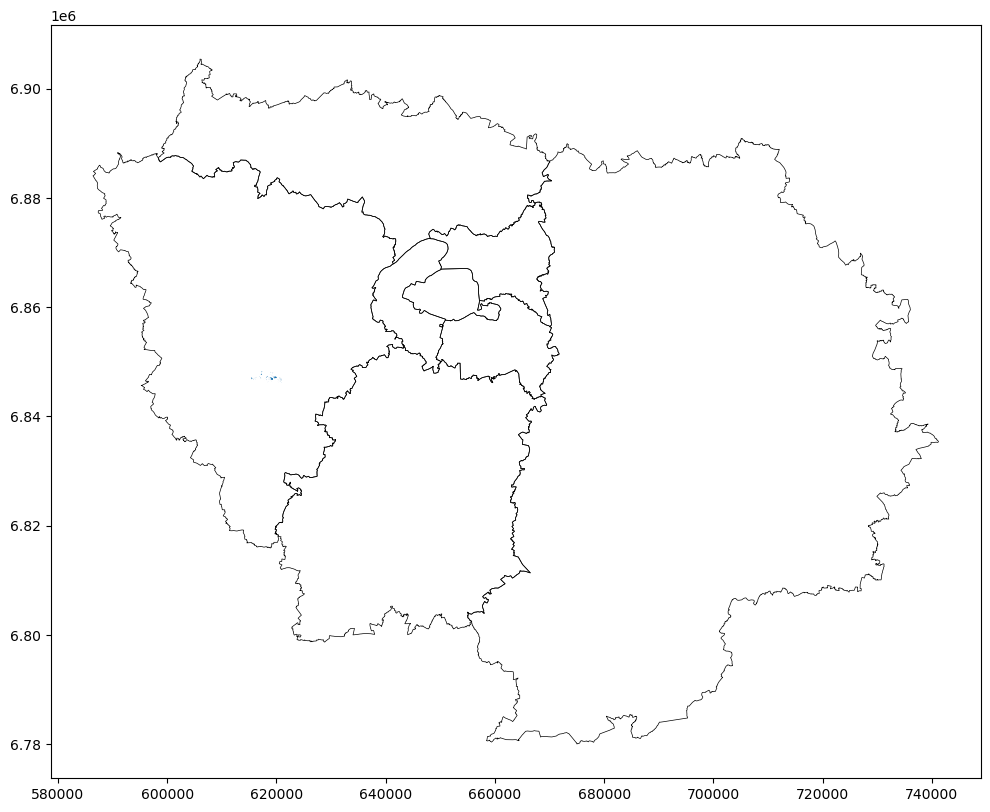

In [56]:
idf = cartiflette.carti_download(
    values=["11"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="REGION",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

departements_idf = idf.loc[
    idf["INSEE_DEP"].isin(["75","77", "78", "91", "92", "93", "94", "95"])
].to_crs(2154)

fig, ax = plt.subplots(figsize=(12, 12))
base = departements_idf.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, figsize=(10, 10))

data_mut_et_insee_pour_vis = data_mut_et_insee
data_mut_et_insee_pour_vis["geometry"] = data_mut_et_insee_pour_vis["geometry"].to_crs(2154)

data_mut_et_insee_pour_vis.plot(ax=ax)

plt.show()



On aperçoit une toute petite tache vers la gauche : vient du fait qu'on a testé l'API sur une commune spécifique (de code Insee 78220, les essarts le roi)
= > il faudra ajuster l'API et le fond de carte selon la commune choisie